In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


# Step 2: Import Libraries
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt




In [ ]:
folder_path = '/content/drive/MyDrive/fypdata2/testcam2pose'

# Step 4: Load PNG files from the folder
pose_images = []
image_paths = []

for filename in os.listdir(folder_path):
    if filename.endswith(".png"):
        img_path = os.path.join(folder_path, filename)
        image_paths.append(img_path)
        img = cv2.imread(img_path)
        pose_images.append(img)

print(f"Loaded {len(pose_images)} images.")

Loaded 2413 images.


In [ ]:
!pip install mediapipe

import mediapipe as mp
mp_pose = mp.solutions.pose

pose_estimator = mp_pose.Pose()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 21.6 MB/s eta 0:00:00


In [ ]:
def extract_keypoints(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = pose_estimator.process(image_rgb)
    if result.pose_landmarks:
        keypoints = []
        for landmark in result.pose_landmarks.landmark:
            keypoints.append([landmark.x, landmark.y])
        return np.array(keypoints).flatten()  # Flatten to a vector of (x1, y1, x2, y2, ...)
    else:
        return None

# Process all images to extract keypoints
keypoints_list = []
valid_images = []

for img in pose_images:
    keypoints = extract_keypoints(img)
    if keypoints is not None:
        keypoints_list.append(keypoints)
        valid_images.append(img)

keypoints_array = np.array(keypoints_list)
print(f"Extracted keypoints from {len(keypoints_array)} valid images.")


Extracted keypoints from 85 valid images.


In [ ]:
def normalize_pose(keypoints):
    x_coords = keypoints[::2]
    y_coords = keypoints[1::2]

    # Normalize coordinates between 0 and 1 (based on height of the person)
    height = np.max(y_coords) - np.min(y_coords)
    keypoints_normalized = keypoints / height
    return keypoints_normalized

keypoints_normalized = np.array([normalize_pose(kp) for kp in keypoints_array])

In [ ]:
n_clusters = 8  # Adjust this value based on how many different poses you expect
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(keypoints_normalized)

In [ ]:
labels, counts = np.unique(kmeans.labels_, return_counts=True)
most_common_cluster = labels[np.argmax(counts)]

In [ ]:
cluster_indices = np.where(kmeans.labels_ == most_common_cluster)[0]
cluster_poses = keypoints_normalized[cluster_indices]

In [ ]:
centroid_pose = np.mean(cluster_poses, axis=0)

In [ ]:
from sklearn.metrics import pairwise_distances
closest_pose_index = np.argmin(pairwise_distances(cluster_poses, centroid_pose.reshape(1, -1)))
representative_pose = valid_images[cluster_indices[closest_pose_index]]


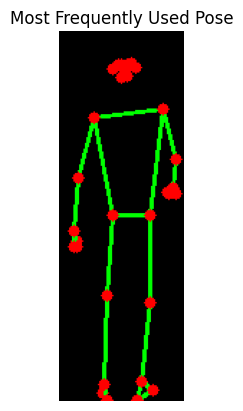

In [ ]:
plt.imshow(cv2.cvtColor(representative_pose, cv2.COLOR_BGR2RGB))
plt.title("Most Frequently Used Pose")
plt.axis('off')
plt.show()

In [ ]:
#save this pose image
cv2.imwrite('most_frequently_used_pose.png', representative_pose)

True